In [7]:
import redshift_connector
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [11]:
with open("redshift_creds.txt", "r") as f:
    host = f.readline()[:-1]
    password= f.readline()[:-1]

In [13]:
conn = redshift_connector.connect(
     host=host,
     database='dev',
     user='app_user',
     password=password
  )

In [14]:
conn.close()

In [98]:
cursor = conn.cursor()

#### Looking at all tables needed

In [99]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT DISTINCT tablename FROM pg_table_def")
result = cursor.fetchall()
for i in result:
    if i[0].startswith('mag_main') | i[0].startswith('mag_advanced'):
        print(i[0])

mag_advanced_entity_related_entities
mag_advanced_field_of_study_children
mag_advanced_field_of_study_extended_attributes
mag_advanced_fields_of_study
mag_advanced_paper_fields_of_study
mag_advanced_paper_mesh
mag_advanced_paper_recommendations
mag_advanced_related_field_of_study
mag_main_affiliations
mag_main_author_extended_attributes
mag_main_authors
mag_main_conference_instances
mag_main_conference_series
mag_main_journals
mag_main_paper_author_affiliations
mag_main_paper_extended_attributes
mag_main_paper_references_id
mag_main_paper_resources
mag_main_paper_urls
mag_main_papers


#### Checking the column names for a specific table

In [205]:
query = """SELECT *
  FROM information_schema.columns
 WHERE table_name   = 'mag_advanced_field_of_study_children'"""

In [206]:
cursor.execute("ROLLBACK;")
cursor.execute(query)
result = cursor.fetchall()
for i in result:
    print(i[3])

child_field_of_study_id
field_of_study_id


### Looking at some papers

##### The following query "explodes" the hierarchy to add tags. Not sure if this method will be used in training. Might stick with the given tags so that the model does not get confused. I don't think I want multiple level 0s to be tagged every time which is what seems might happen if the exploding hierarchy is used.

In [240]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, a.journal_id, b.normalized_name,
        c.field_of_study, d.normalized_name as topic_name, d.display_name,
        d.rank, f.parent_name, f.parent_level, h.parent2_name, h.parent2_level,
        j.parent3_name, j.parent3_level
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE paper_id=2216470333) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) e
ON c.field_of_study=e.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent_name, field_of_study_id, 
                  level as parent_level
           FROM mag_advanced_fields_of_study) f
ON f.field_of_study_id=e.parent_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent2_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) g
ON e.parent_field_of_study_id=g.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent2_name, field_of_study_id, 
                  level as parent2_level
           FROM mag_advanced_fields_of_study) h
ON h.field_of_study_id=g.parent2_field_of_study_id
LEFT JOIN (SELECT field_of_study_id as parent3_field_of_study_id, 
                  child_field_of_study_id
           FROM mag_advanced_field_of_study_children) i
ON g.parent2_field_of_study_id=i.child_field_of_study_id
LEFT JOIN (SELECT normalized_name as parent3_name, field_of_study_id, 
                  level as parent3_level
           FROM mag_advanced_fields_of_study) j
ON j.field_of_study_id=i.parent3_field_of_study_id
"""

### -------------------------------------------

##### The following query is to attach the journal and tag name info to each paper

In [261]:
journal_join_query = \
"""
SELECT  a.paper_id, a.doc_type, a.paper_title, a.year, 
        a.publication_date, a.journal_id, b.normalized_name as journal_name,
        c.field_of_study, d.normalized_name as topic_name, d.display_name,
        d.level 
FROM (SELECT paper_id, doc_type, paper_title, book_title, year, 
             publication_date, online_date, journal_id
      FROM mag_main_papers 
      WHERE random() <= .0004) a
LEFT JOIN (SELECT journal_id, normalized_name
           FROM mag_main_journals) b
ON a.journal_id=b.journal_id
LEFT JOIN (SELECT *
           FROM mag_advanced_paper_fields_of_study) c
ON a.paper_id=c.paper_id
LEFT JOIN (SELECT *
           FROM mag_advanced_fields_of_study) d
ON c.field_of_study=d.field_of_study_id
"""

In [262]:
cursor.execute("ROLLBACK;")
cursor.execute(journal_join_query)
df = cursor.fetch_dataframe()
df.shape

(617664, 11)

In [263]:
df.columns

Index(['paper_id', 'doc_type', 'paper_title', 'year', 'publication_date',
       'journal_id', 'journal_name', 'field_of_study', 'topic_name',
       'display_name', 'level'],
      dtype='object')

In [264]:
df['paper_id'].value_counts()

2364388555    13
2353023081    13
2240444139    13
1985722532    13
2156971099    13
              ..
2281815877     1
2232771135     1
1558821466     1
896268301      1
3154030603     1
Name: paper_id, Length: 103406, dtype: int64

#### This was done as a test to see how an explosion would work for a single paper (using explosion query above)

In [244]:
len([x for x in list(set(df['parent_name'].unique().tolist() + 
                         df['topic_name'].unique().tolist() + 
                         df['parent2_name'].unique().tolist() + 
                         df['parent3_name'].unique().tolist())) if x is not None])

23

In [245]:
df[df['paper_id']==2216470333]

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,topic_name,display_name,rank,parent_name,parent_level,parent2_name,parent2_level,parent3_name,parent3_level
0,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,biochemistry,1.0,chemistry,0.0
1,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,biochemistry,1.0,chemistry,0.0
2,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,biochemistry,1.0,chemistry,0.0
3,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,biochemistry,1.0,chemistry,0.0
4,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,198684833,specific activity,Specific activity,10858,enzyme,2.0,organic chemistry,1.0,chemistry,0.0
5,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,anatomy,1.0,medicine,0.0
6,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urinary system,2.0,endocrinology,1.0,medicine,0.0
7,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,creatinine,2.0,endocrinology,1.0,medicine,0.0
8,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,urine,2.0,endocrinology,1.0,medicine,0.0
9,2216470333,Journal,estimating energy expenditure from specific ac...,1995,1995-07-01,196637695,american journal of physiology endocrinology a...,2778596287,urine collection device,Urine collection device,13603,excretion,2.0,endocrinology,1.0,medicine,0.0


### ------------------------------------------------------

In [265]:
df.drop_duplicates(subset=['paper_id'])['doc_type'].value_counts()

Journal        35333
Patent         25883
Thesis          2172
Conference      1977
Repository      1925
Book            1747
BookChapter     1506
Dataset           52
Name: doc_type, dtype: int64

In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617664 entries, 0 to 617663
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   paper_id          617664 non-null  int64  
 1   doc_type          492117 non-null  object 
 2   paper_title       617664 non-null  object 
 3   year              617493 non-null  float64
 4   publication_date  617493 non-null  object 
 5   journal_id        285925 non-null  float64
 6   journal_name      285925 non-null  object 
 7   field_of_study    595481 non-null  float64
 8   topic_name        595481 non-null  object 
 9   display_name      595481 non-null  object 
 10  level             595481 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 51.8+ MB


In [267]:
df[df['field_of_study'].isnull()].sample(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,journal_name,field_of_study,topic_name,display_name,level
587129,2596657702,Journal,buch anzeigen practische notiz,1895.0,1895-01-01,135397728.0,dermatology,NaN,None,None,NaN
562060,2895693277,None,elaboracao de produtos alimenticios a partir d...,2018.0,2018-10-02,NaN,None,NaN,None,None,NaN
583491,587614821,None,モニター心電図 かんたん マスター 第21回 part3 急変で出会う不整脈事例 10 ペー...,2006.0,2006-09-01,NaN,None,NaN,None,None,NaN
612627,2563424288,None,korelasi panjang baku dan berat ikan arius cae...,2016.0,2016-04-18,NaN,None,NaN,None,None,NaN
547509,889394325,None,螺旋人生 记我国锥齿轮专家 洛阳工学院教授梁桂明,2000.0,2000-01-01,NaN,None,NaN,None,None,NaN


### Used the following code to check language of the title and run some stats on those vs field of study being blank

In [153]:
from langdetect import detect

In [154]:
temp_df = df.drop_duplicates(subset=['paper_id']).copy()

In [155]:
def get_lang(x):
    try:
        lang = detect(x)
    except:
        lang = 'UNK'
    return lang

In [156]:
temp_df['lang'] = temp_df['paper_title'].apply(lambda x: get_lang(x))

In [157]:
temp_df.head(5)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
0,1722040101,Journal,the development of larval resistance to a nucl...,2000.0,2000-09-01,172494440.0,evolutionary ecology,8.680324e+07,biology,Biology,4432,None,0.0,en
1,2226449916,Patent,electric contact element for electrochemical d...,2000.0,2000-12-05,NaN,None,6.880162e+07,electrolyte,Electrolyte,8064,None,3.0,en
2,2239066496,None,samuel wetherill s self publishing or quaker d...,2014.0,2014-01-08,NaN,None,2.777800e+09,independence,Independence,10140,media_common.quotation_subject,2.0,en
3,2752449863,Journal,commercial intravenous immunoglobulin preparat...,2017.0,2017-11-01,47215897.0,antimicrobial agents and chemotherapy,2.777806e+09,leukocidin,Leukocidin,13609,None,4.0,en
4,2300157463,Patent,method and system for locating devices during ...,1999.0,1999-03-18,NaN,None,1.274136e+08,engineering,Engineering,4855,business.industry,0.0,en


### Looking at the sample of data to see which % of english and non-english papers have a field of study

In [160]:
temp_df.shape[0]

104017

#### % That are english and have field of study out of all english

In [162]:
(temp_df[(temp_df['lang']=='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

97.42521513454446

#### % That are english and no field of study out of all english

In [164]:
(temp_df[(temp_df['lang']=='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']=='en')].shape[0])*100

2.574784865455539

#### % That are non-english and have field of study out of all non-english

In [165]:
(temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

32.93082740935502

#### % That are non-english and no field of study out of all non-english

In [166]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df[(temp_df['lang']!='en')].shape[0])*100

67.06917259064498

In [168]:
(temp_df[(temp_df['lang']!='en') & (temp_df['field_of_study'].isnull())].shape[0])/ \
(temp_df.shape[0])*100

19.864060682388455

#### % of sample papers for the top 10 languages

In [159]:
(temp_df['lang'].value_counts()/temp_df.shape[0]*100)[:10]

en       70.382726
fr        3.770538
es        3.352337
de        3.113914
ja        3.089880
ko        2.491900
it        2.132344
pt        1.537249
zh-cn     1.335359
id        1.271907
Name: lang, dtype: float64

In [167]:
temp_df[(temp_df['lang']!='en') & (~temp_df['field_of_study'].isnull())].sample(20)

,paper_id,doc_type,paper_title,year,publication_date,journal_id,normalized_name,field_of_study,normalized_name,display_name,rank,main_type,level,lang
363146,2022025267,None,l occupation militaire pouvoirs reconnus aux f...,1962.0,1962-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr
372549,2561793121,None,verbalni komunikace a lidska psychika,2007.0,2007-01-01,NaN,None,1.574497e+07,psychology,Psychology,5223,None,0.0,hr
23000,2997029165,None,upaya pemerintah jepang dalam perelokasian pan...,2018.0,2018-07-07,NaN,None,1.961792e+08,economic problem,Economic problem,11779,None,2.0,id
56676,2064224311,Conference,a vertical distribution ltcc duplexer,2011.0,2011-11-03,NaN,None,2.432624e+07,electronic engineering,Electronic engineering,6389,None,1.0,ca
150960,3146167721,Patent,pet traction device,2019.0,2019-07-16,NaN,None,9.390403e+06,computer hardware,Computer hardware,6781,business.industry,1.0,fr
51792,2927375358,Patent,multi channel laser output device,2014.0,2014-08-11,NaN,None,1.195995e+08,electrical engineering,Electrical engineering,6022,business.industry,1.0,fr
421323,2850259760,Patent,procede et machine de poinconnage de pieces de...,2012.0,2012-09-28,NaN,None,1.925624e+08,materials science,Materials science,4137,None,0.0,fr
18318,210506594,None,カイワレ栽培における成長とカチオン ca mg k 含有量に及ぼす磁場と音波の効果,2008.0,2008-06-01,NaN,None,1.152607e+08,magnetic field,Magnetic field,7809,None,2.0,ja
10980,3110519847,Patent,coating glue supply temperature control device,2020.0,2020-07-24,NaN,None,2.012897e+08,inlet,Inlet,7804,geography.geographical_feature_category,2.0,it
303500,1552380730,Book,droit international prive,1987.0,1987-01-01,NaN,None,1.774444e+07,political science,Political science,6001,None,0.0,fr


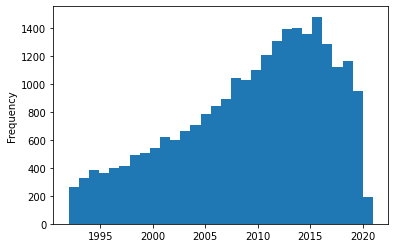

In [284]:
# histogram showing journals of the past 30 years that are not in english (on its way down after peaking in ~2013)
temp_df[(temp_df['lang']!='en') & (temp_df['year'] > 1991)]['year'].plot.hist(bins=30)
plt.show()

#### Check Journals

In [92]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_main_journals")
df = cursor.fetch_dataframe()

#### Check Field of Study

In [146]:
cursor.execute("ROLLBACK;")
cursor.execute("SELECT * FROM mag_advanced_fields_of_study")
mag_fields = cursor.fetch_dataframe()
mag_fields.shape

(718697, 10)

In [147]:
mag_fields['level'].value_counts()

3.0    357425
2.0    159323
4.0    124331
5.0     77303
1.0       292
0.0        19
Name: level, dtype: int64

In [149]:
mag_fields[mag_fields['level']==0.0]

,field_of_study_id,rank,normalized_name,display_name,main_type,level,paper_count,paper_family_count,citation_count,create_date
12099,127313418,5728,geology,Geology,None,0.0,7229938.0,7146333.0,39081212.0,2016-06-24
73790,205649164,6293,geography,Geography,None,0.0,4577091.0,4555936.0,21098112.0,2016-06-24
110692,185592680,4358,chemistry,Chemistry,None,0.0,18501883.0,17694356.0,238074571.0,2016-06-24
129233,33923547,5125,mathematics,Mathematics,None,0.0,6999822.0,6698419.0,81954218.0,2016-06-24
131082,192562407,4137,materials science,Materials science,None,0.0,30842052.0,29409414.0,173450325.0,2016-06-24
131509,138885662,7248,philosophy,Philosophy,None,0.0,2086370.0,2081982.0,5001790.0,2016-06-24
207151,41008148,4250,computer science,Computer science,None,0.0,26826626.0,25672825.0,151405340.0,2016-06-24
270489,17744445,6001,political science,Political science,None,0.0,6751171.0,6690167.0,21566953.0,2016-06-24
293109,39432304,5852,environmental science,Environmental science,None,0.0,6190085.0,6121022.0,36169558.0,2016-06-24
294653,15744967,5223,psychology,Psychology,None,0.0,7998148.0,7954010.0,111798077.0,2016-06-24
